<a href="https://colab.research.google.com/github/selimunal/Pytorch/blob/main/PyTorch_S%C4%B1mpleRNN_S%C4%B1ne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

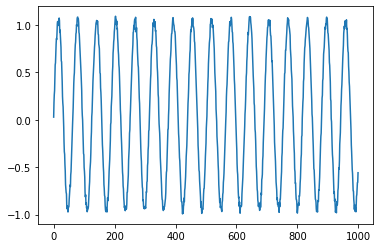

In [ ]:
#make the original data
N=1000
series=np.sin(0.1*np.arange(N)) +np.random.rand(N)*0.1

#plot it
plt.plot(series)
plt.show()

In [ ]:
#build the dataset
#lets see if we can use T past value to predict the next value
T=10
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T,1)
Y=np.array(Y).reshape(-1,1)
N=len(X)

print("X shape",X.shape,"Y shape",Y.shape)


X shape (990, 10, 1) Y shape (990, 1)


In [ ]:
len(series)

1000

In [ ]:
#set device
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self,n_inputs,n_hidden,n_rnnlayers,n_outputs):
    super(SimpleRNN,self).__init__()
    self.D=n_inputs
    self.M=n_hidden
    self.K=n_outputs
    self.L=n_rnnlayers

    #note batch_first=True
    #applies the convestion that our data will be of shape :
    # (num_samples,sequentce_length,num_features)
    # rather than:
    # (sequence_length,num_samples, num_features)
    self.rnn=nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True
    )
    self.fc=nn.Linear(self.M,self.K)

  def forward(self,X):
    #initial hidden states
    h0=torch.zeros(self.L,X.size(0),self.M).to(device)

    #get RNN unit output
    #output size (N,T,M)
    #2nd return value is hidden states at each hidden layer
    
    out,_=self.rnn(X,h0)

    #we only want h(T) at the final time step
    #NxM-> NxK
    out=self.fc(out[:,-1,:])
    return out

In [ ]:
model=SimpleRNN(n_inputs=1,n_hidden=5,n_rnnlayers=1,n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#loss and optimizer
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.1)


In [ ]:
#make inouts and targets
X_train=torch.from_numpy(X[:-N//2].astype(np.float32))
y_train=torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test=torch.from_numpy(X[-N//2:].astype(np.float32))
y_test=torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
#move data to GPU
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

In [ ]:
#Training
def full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test,epochs=200):

  #stuff to store
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)

  for it in range(epochs):
    #zero the parameter gradients
    optimizer.zero_grad()

    #forward pass
    outputs=model(X_train)
    loss=criterion(outputs,y_train)

    #backward and optimize
    loss.backward()
    optimizer.step()

    #save losses
    train_losses[it]=loss.item()

    #test loss
    test_outputs=model(X_test)
    test_loss=criterion(test_outputs,y_test)
    test_losses[it]= test_loss.item()

    if  (it+1) %5==0:
      print(f'Epoch {it+1}/{epochs}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f}')
    
  return train_losses,test_losses

In [ ]:
train_losses, test_losses= full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test)

Epoch 5/200, train loss: 0.3804, test loss: 0.3608
Epoch 10/200, train loss: 0.1243, test loss: 0.0624
Epoch 15/200, train loss: 0.0797, test loss: 0.1007
Epoch 20/200, train loss: 0.0337, test loss: 0.0210
Epoch 25/200, train loss: 0.0318, test loss: 0.0352
Epoch 30/200, train loss: 0.0259, test loss: 0.0196
Epoch 35/200, train loss: 0.0099, test loss: 0.0109
Epoch 40/200, train loss: 0.0143, test loss: 0.0115
Epoch 45/200, train loss: 0.0067, test loss: 0.0073
Epoch 50/200, train loss: 0.0084, test loss: 0.0083
Epoch 55/200, train loss: 0.0055, test loss: 0.0059
Epoch 60/200, train loss: 0.0062, test loss: 0.0063
Epoch 65/200, train loss: 0.0052, test loss: 0.0056
Epoch 70/200, train loss: 0.0054, test loss: 0.0057
Epoch 75/200, train loss: 0.0051, test loss: 0.0055
Epoch 80/200, train loss: 0.0052, test loss: 0.0055
Epoch 85/200, train loss: 0.0051, test loss: 0.0055
Epoch 90/200, train loss: 0.0051, test loss: 0.0055
Epoch 95/200, train loss: 0.0051, test loss: 0.0055
Epoch 100/200

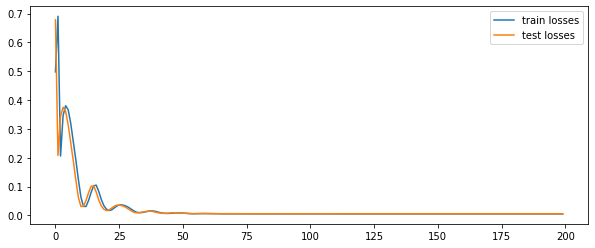

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_losses,label='train losses')
plt.plot(test_losses,label='test losses')
plt.legend()
plt.show()

In [ ]:
#wrong method
val_tar=Y[-N//2:]
val_pred=[]

#index of first validation input
i=0

while len(val_pred)<len(val_tar):
  input_=X_test[i].view(1,T,-1)
  p=model(input_)[0,0].item() #1x1 array -> scalar
  i+=1

  #update the list
  val_pred.append(p)

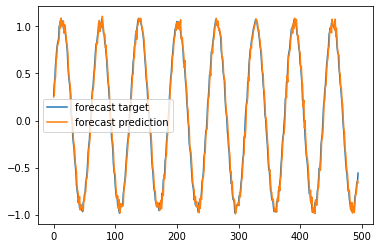

In [ ]:
plt.plot(val_tar,label='forecast target')
plt.plot(val_pred,label='forecast prediction')
plt.legend()
plt.show()

In [ ]:
#CORRECT METHOD
val_tar=Y[-N//2:]
val_pred=[]

# last_x=torch.from_numpy(X[-N//2].astype(np.float32))
last_x=X_test[0].view(T)

while len(val_pred)<len(val_tar):
  input_=last_x.view(1,T,-1)
  p=model(input_)

#update the prediction list
  val_pred.append(p[0,0].item())

  #make new input
  last_x=torch.cat((last_x[1:],p[0]))

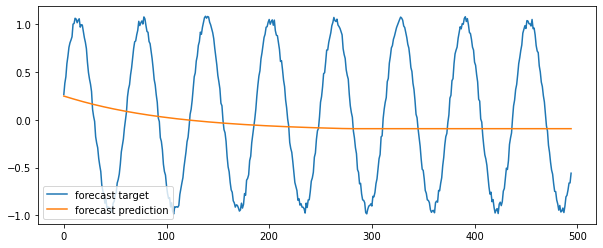

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(val_tar,label='forecast target')
plt.plot(val_pred,label='forecast prediction')
plt.legend()
plt.show()

In [ ]:
#things to remember
#N=number of samples
# T=sequence length
# D=number of input features
# M=number of hidden units
# K=number of output units

In [ ]:
#make some data
#N=1
N=2
T=10
D=3
M=5
K=2
X=np.random.randn(N,T,D)

In [ ]:
#make an RNN
class SimpleRNN(nn.Module):
  def __init__(self,n_inputs,n_hidden,n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        nonlinearity="tanh",
        batch_first=True)
    self.fc=nn.Linear(self.M,self.K)

  def forward(self,X):
      #initial hidden states
    h0=torch.zeros(1,X.size(0),self.M)

      #get RNN unit output
    out,_=self.rnn(X,h0)

      #we only want h(T) at the final time step
    #out=self.fc(out[:,-1,:])
    out=self.fc(out)
    return out

In [ ]:
#instattiate the model
model=SimpleRNN(n_inputs=D,n_hidden=M,n_outputs=K)

In [ ]:
#get output
inputs=torch.from_numpy(X.astype(np.float32))
out=model(inputs)
out

tensor([[[ 0.4653, -0.0574],
         [ 0.0321,  0.1324],
         [ 0.4544, -0.0369],
         [ 0.1719,  0.1001],
         [ 0.3485, -0.0075],
         [ 0.3837, -0.0998],
         [ 0.2532,  0.0083],
         [ 0.3196,  0.0031],
         [ 0.5953, -0.2175],
         [ 0.3598, -0.0099]],

        [[ 0.5283, -0.1082],
         [ 0.2745,  0.0130],
         [ 0.4419, -0.0229],
         [ 0.3406, -0.0165],
         [ 0.5976, -0.1305],
         [ 0.2067, -0.0235],
         [ 0.4511, -0.1636],
         [ 0.0934,  0.1624],
         [ 0.2254,  0.0841],
         [ 0.0422,  0.1773]]], grad_fn=<AddBackward0>)

In [ ]:
out.shape

torch.Size([2, 10, 2])

In [ ]:
X.shape

(2, 10, 3)

In [ ]:
#save for later
Yhats_torch=out.detach().numpy()

In [ ]:
Yhats_torch.shape

(2, 10, 2)

In [ ]:
W_xh,W_hh,b_xh,b_hh=model.rnn.parameters()

In [ ]:
W_xh.shape

torch.Size([5, 3])

In [ ]:
W_xh

Parameter containing:
tensor([[-0.3147, -0.3931,  0.1010],
        [-0.1257,  0.3823, -0.0698],
        [ 0.3799,  0.3271,  0.2283],
        [-0.0757, -0.4435,  0.3676],
        [-0.1117, -0.0463,  0.1209]], requires_grad=True)

In [ ]:
W_xh=W_xh.data.numpy()
W_xh

array([[-0.3147231 , -0.39307818,  0.10103261],
       [-0.12571394,  0.38230494, -0.06980568],
       [ 0.37989822,  0.32705754,  0.22826147],
       [-0.07568931, -0.44348702,  0.36756012],
       [-0.11169667, -0.04632691,  0.12094662]], dtype=float32)

In [ ]:
W_xh.shape

(5, 3)

In [ ]:
b_xh=b_xh.data.numpy()
W_hh=W_hh.data.numpy()
b_hh=b_hh.data.numpy()

In [ ]:
W_xh.shape,b_xh.shape,W_hh.shape,b_hh.shape

((5, 3), (5,), (5, 5), (5,))

In [ ]:
#now get the FC layer weights
Wo,bo=model.fc.parameters()

In [ ]:
Wo.shape

torch.Size([2, 5])

In [ ]:
Wo=Wo.data.numpy()
bo=bo.data.numpy()
Wo.shape, bo.shape

((2, 5), (2,))

In [ ]:
#see if we can replicate the output
h_last1=np.zeros(M) #initial hidden state
h_last2=np.zeros(M)
x1=X[0] #the one and only sample
x2=X[1]
Yhats1=np.zeros((T,K))# where we store the outputs
Yhats2=np.zeros((T,K))
for t in range(T):
  h1=np.tanh(x1[t].dot(W_xh.T)+b_xh + h_last1.dot(W_hh.T)+b_hh)
  h2=np.tanh(x2[t].dot(W_xh.T)+b_xh + h1.dot(W_hh.T)+b_hh)
  y1=h1.dot(Wo.T)+bo
  y2=h2.dot(Wo.T)+bo
  Yhats1[t]=y1
  Yhats2[t]=y2

  #important: assign h to h last
  h_last=np.dot(h1,h2)

#print the final output
print(Yhats1, Yhats2)

[[-0.22186035  0.04756345]
 [ 0.0224201  -0.33671142]
 [-0.10871153  0.10524257]
 [-0.06158309  0.06948113]
 [-0.14832055  0.17869296]
 [-0.3019412   0.35711164]
 [-0.13222327  0.28049751]
 [ 0.02198773 -0.0845366 ]
 [-0.57206878  1.00433738]
 [-0.16979193  0.39527631]] [[-0.31345749  0.43086005]
 [-0.0425579  -0.06005168]
 [-0.31109563  0.79757181]
 [ 0.02035042 -0.03488629]
 [-0.40720111  0.69598225]
 [-0.08962659 -0.12169238]
 [-0.04404093 -0.31645119]
 [ 0.11968569 -0.43427936]
 [-0.06325373 -0.37482471]
 [ 0.10370967 -0.39358004]]


In [ ]:
Yhats1.shape

(10, 2)

In [ ]:
np.multiply(Yhats1,Yhats2).shape

(10, 2)

In [ ]:
Yhats2.shape

(10, 2)

In [ ]:
Yhats_torch.shape

(2, 10, 2)

In [ ]:
np.allclose(Yhats, Yhats_torch)

NameError: ignored